In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress
from datetime import timedelta  
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import sys

import time
import datetime
import matplotlib.dates as mdates

import import_ipynb #### only use it when you are in Jupyter environment
import multiprocessing as mp
from mpi4py import MPI
from utils_common import *

_Figure_PATH_ = './figures_US/parameters/'
_Data_PATH_ = './data_US/parameters/'
_State_PATH_ = './data_US/data_NYT_state.csv'

importing Jupyter notebook from utils_common.ipynb


In [2]:
def load_NYT_raw():
    raw_state = pd.read_csv(_State_PATH_) 
    raw_state['update_date'] = pd.to_datetime(raw_state['update_date'])
    raw_state['update_date'] = raw_state['update_date'].dt.date
    return raw_state

In [27]:
# SEIR simulation for every state
# ’leastsq’: Levenberg-Marquardt (default)
# ’emcee’: Maximum likelihood via Monte-Carlo Markov Chain
# ’dual_annealing’: Dual Annealing optimization
# beta, sigma and gamma are all time-dependent
def simulation_state(df, update_date_tr, update_date_sd, rank = 0, mmethod = 'dual_annealing', kws = False):
    
    start_time = time.time()
    state = names_state[rank]
    df = df[df.update_date <= update_date_tr]
    df_single = df[df['state_name'] == state]
    
    timespan_parameter = (update_date_tr - min(df_single.update_date)).days + 1
    
    T_list = [0]*len(update_date_sd)
    index_list = []
    for i, d in enumerate(update_date_sd):
        T_list[i] = max((d - min(df_single.update_date)).days + 1, 0)
        if i == 0:
            index_list += [i]*T_list[i]
        else:
            index_list += [i]*(T_list[i] - T_list[i - 1])
            
    index_list += [i + 1]*(timespan_parameter - T_list[i])
    
    
    # Least-square fitting
    def SEIR_equations(states, t, ps):
        """Receptor synthesis-internalization model."""

        beta_index = index_list[min(round(t), timespan_parameter - 1)]
        gamma_index = index_list[min(round(t), timespan_parameter - 1)]
        sigma_index = index_list[min(round(t), timespan_parameter - 1)]
        
        beta = ps['beta_' + str(beta_index)].value
        gamma = ps['gamma_' + str(gamma_index)].value
        sigma = ps['sigma_' + str(sigma_index)].value
        N = ps['N'].value

        S, E, I, R = states

        return [-beta*S*I/N, beta*S*I/N - sigma*E, sigma*E - gamma*I, gamma*I]
    
    def SEIR(states_0, ts, ps):
        """
        Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
        """
        states = odeint(SEIR_equations, states_0, ts, args=(ps,))
        return states
    
    # Calculate the residual
    def residual(ps, ts, data):
        states_0 = ps['S_0'].value, ps['E_0'].value, ps['I_0'].value, ps['R_0'].value
        model = SEIR(states_0, ts, ps)
        est = model[:,3]
        return (est - data).ravel()
    
    # Calculate the estimation
    def estimation(ps, ts):
        states_0 = ps['S_0'].value, ps['E_0'].value, ps['I_0'].value, ps['R_0'].value
        model = SEIR(states_0, ts, ps)
        est = model[:,3]
        return est

    ts = range(0, timespan_parameter)
    ts_date = [item for item in daterange(min(df_single.update_date), update_date_tr)]
    # change beta per TI days for the first t_0 days, then change beta per ti days
    
    data = np.array(df_single.cum_confirmed)
    

    # Set parameters incluing bounds
    ps_bound = Parameters()
    ps_bound.add(name = 'N', value = state_population_dict.get(state), vary = False)
    ps_bound.add(name = 'E_0', value = 50, min = 0, max = 1000)
    ps_bound.add(name = 'I_0', value = 50, min = 0, max = 500)
    ps_bound.add(name = 'R_0', value = 0, min = 0, max = 100)
    ps_bound.add(name = 'S_0', expr = 'N - E_0 - I_0 - R_0')
    for i in range(max(index_list) + 1):
        #ps_bound.add(name = 'beta_' + str(int(i)), value = 0.5, min = 0.01, max = 1)
        ps_bound.add(name = 'beta_' + str(int(i)), value = 0.5, min = 0.01, max = 3)
    for i in range(max(index_list) + 1):
        #ps_bound.add(name = 'gamma_' + str(int(i)), value = 0.5, min = 0.05, max = 0.5)
        ps_bound.add(name = 'gamma_' + str(int(i)), value = 0.5, min = 0.02, max = 1)
    for i in range(max(index_list) + 1):
        #ps_bound.add(name = 'sigma_' + str(int(i)), value = 0.5, min = 0.05, max = 0.5)
        ps_bound.add(name = 'sigma_' + str(int(i)), value = 0.5, min = 0.02, max = 1)
    
    # Fit model and find predicted values
    if kws == False:
        result = minimize(residual, ps_bound, args = (ts, data), method = mmethod)
    elif mmethod == 'emcee':
        result = minimize(residual, ps_bound, args = (ts, data), method = mmethod, steps = kws.get('steps'))
    elif mmethod == 'dual_annealing':
        result = minimize(residual, ps_bound, args = (ts, data), method = mmethod, maxiter = kws.get('maxiter'), initial_temp = kws.get('initial_temp'))
    elif mmethod == 'differential_evolution':
        result = minimize(residual, ps_bound, args = (ts, data), method = mmethod, maxiter = kws.get('maxiter'))
        
    residual = result.residual.reshape(data.shape)
    final = estimation(result.params, ts)
    
    # Plot real data and fitted curves
    palette = plt.get_cmap('magma')
    fig = plt.figure(figsize = (10,5))
    ax = plt.subplot(111)
    
    parts_list = []
    
    for i, T in enumerate(T_list):
        if i == 0:
            part = [True]*(T + 1) + [False]*(timespan_parameter - T - 1)
        else:
            part = [False]*T_list[i - 1] + [True]*(T - T_list[i - 1] + 1) + [False]*(timespan_parameter - T - 1)
        parts_list.append(part)
        
    parts_list.append([False]*T + [True]*(timespan_parameter - T))
    
    for i, part in enumerate(parts_list):
    
        ax.plot(list(compress(ts_date, part)), list(compress(data, part)),
                 '-o', color = palette(0.2*(i + 1)))
        ax.plot(list(compress(ts_date, part)), list(compress(final, part)),
                 linewidth = 2, color = palette(0.2*(i + 1)))
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.title(state)
    plt.xlabel('Date')
    plt.ylabel('Number of people')
    fig.savefig(_Figure_PATH_ + state + '_conf_SEIR.pdf', dpi = 400)
    
    #print("processor %d of %d" % (rank, size))
    print("--- %s seconds ---" % (time.time() - start_time))
    
    df_parameters = pd.DataFrame(dict(result.params.valuesdict()).items(), columns=['parameter', 'value'])
    df_parameters.to_csv(_Data_PATH_ + state + '_parameters.csv', index = False)
    df_final = pd.DataFrame({'estimation': final, 'real': data, 'residual': residual}, columns=['estimation', 'real', 'residual'])
    df_final.to_csv(_Data_PATH_ + state + '_estimation.csv', index = False)
    return result, df_parameters, df_final

In [3]:
data_state = load_NYT_raw()

In [25]:
# beta, sigma and gamma are all piecewise functions
# the ith piece is from date_sd[i-1] + timedelta(days=1) to date_sd[i]
date_sd = [datetime.date(int(2020),int(3),int(15)), datetime.date(int(2020),int(3),int(29))]
date_tr = datetime.date(int(2020),int(4),int(5))

In [29]:
emcee_kws = dict(steps=10)
differential_evolution_kws = dict(maxiter=1)
annealing_kws = dict(maxiter = 1, initial_temp=1e4)

--- 0.7417378425598145 seconds ---
--- 0.8275840282440186 seconds ---
--- 16.506394863128662 seconds ---
--- 0.9192550182342529 seconds ---
--- 3.183148145675659 seconds ---
--- 4.500659942626953 seconds ---
--- 11.18966293334961 seconds ---
--- 4.482239007949829 seconds ---
--- 5.204450845718384 seconds ---
--- 8.746068239212036 seconds ---
--- 9.781234979629517 seconds ---
--- 0.48293590545654297 seconds ---
--- 5.4131669998168945 seconds ---
--- 2.276550769805908 seconds ---
--- 15.289438009262085 seconds ---
--- 3.5623459815979004 seconds ---
--- 1.7382228374481201 seconds ---
--- 5.8217878341674805 seconds ---
--- 14.164515733718872 seconds ---
--- 6.097504138946533 seconds ---


/Users/xingruchen/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


--- 6.188959836959839 seconds ---
--- 17.792601108551025 seconds ---
--- 15.358463048934937 seconds ---
--- 1.1102869510650635 seconds ---
--- 19.115567922592163 seconds ---
--- 14.110688924789429 seconds ---
--- 0.9587771892547607 seconds ---
--- 0.7149388790130615 seconds ---
--- 13.625592947006226 seconds ---
--- 0.9967188835144043 seconds ---
--- 13.879594087600708 seconds ---
--- 7.490306854248047 seconds ---
--- 21.321727991104126 seconds ---
--- 10.690224885940552 seconds ---
--- 0.15857505798339844 seconds ---
--- 4.203291177749634 seconds ---
--- 6.014837026596069 seconds ---
--- 3.1084039211273193 seconds ---
--- 13.54912519454956 seconds ---
--- 9.48947787284851 seconds ---
--- 5.459650039672852 seconds ---
--- 5.073179006576538 seconds ---
--- 7.800702095031738 seconds ---
--- 12.760320901870728 seconds ---
--- 1.0488219261169434 seconds ---
--- 0.890186071395874 seconds ---
--- 4.497678756713867 seconds ---
--- 7.484339952468872 seconds ---
--- 0.5549910068511963 seconds -

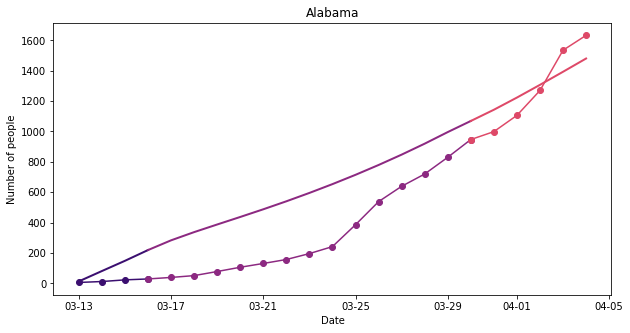

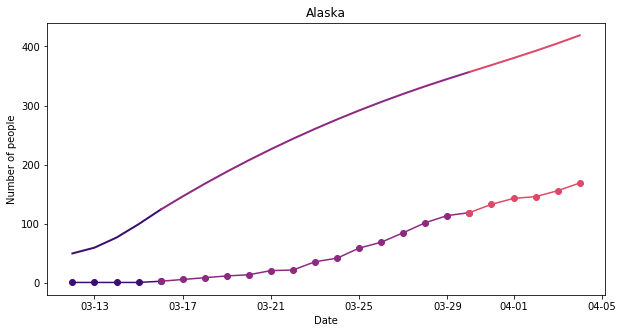

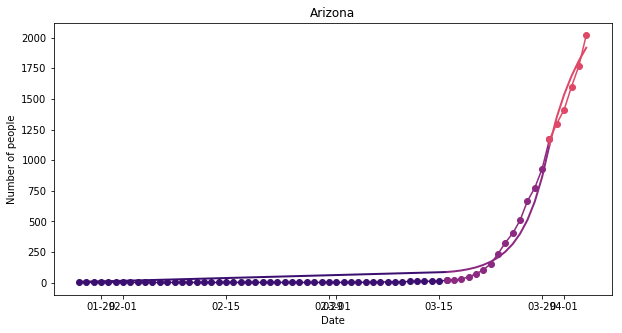

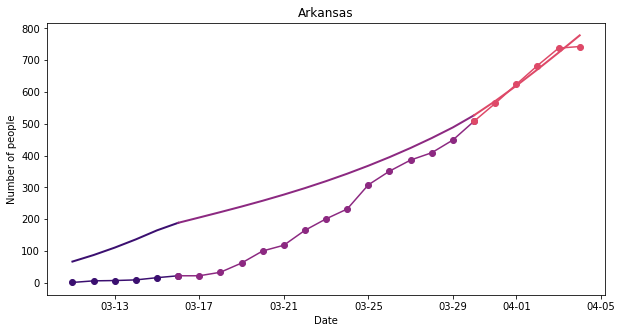

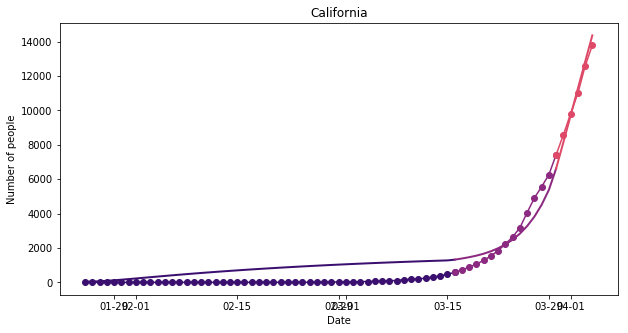

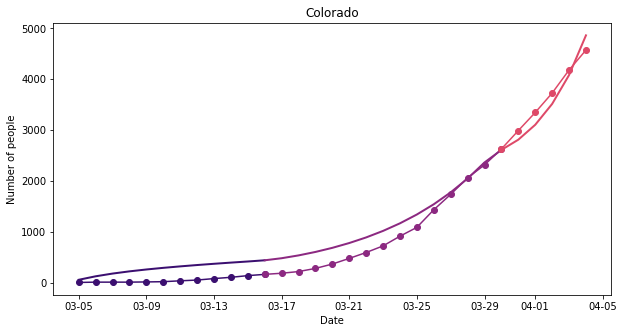

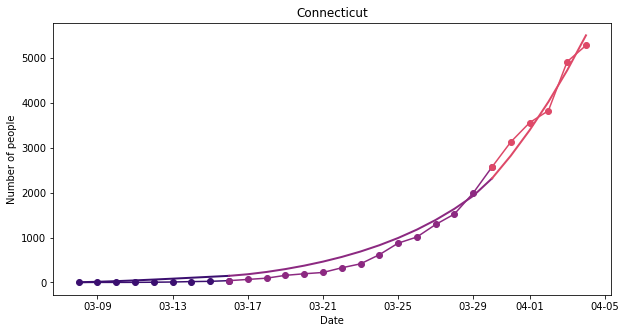

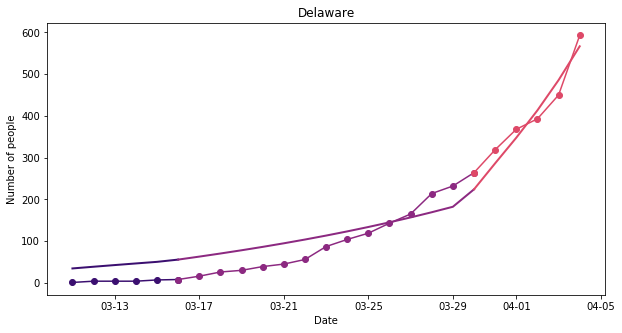

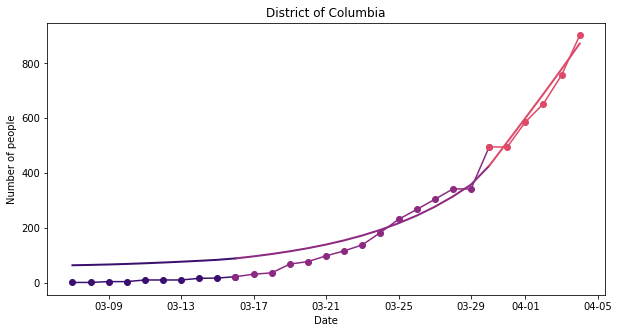

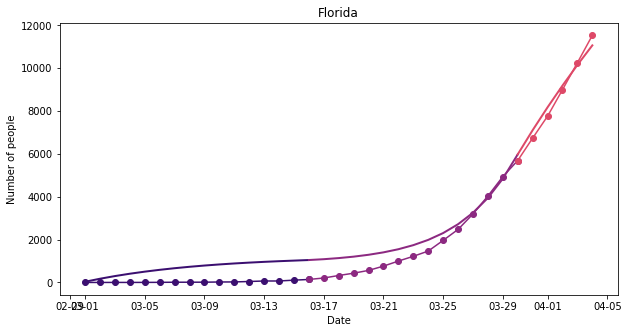

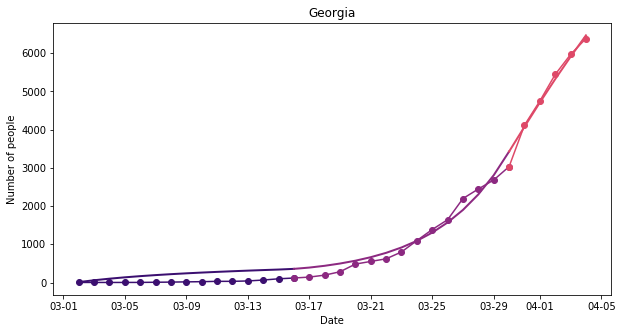

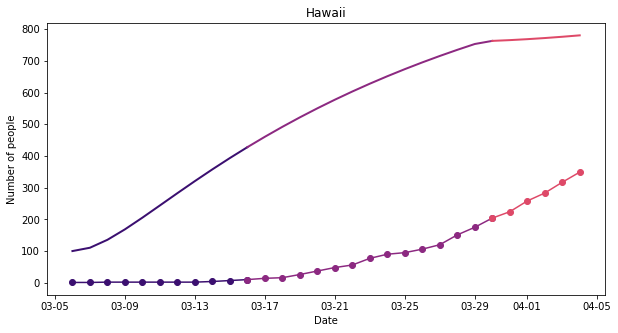

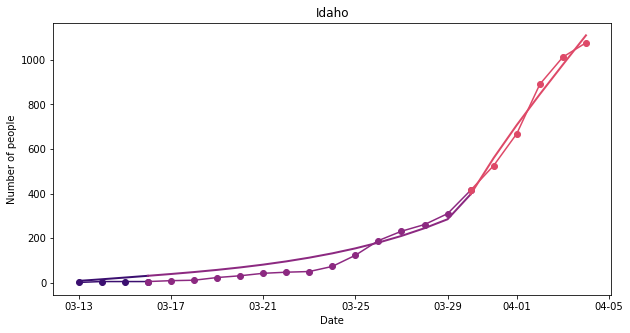

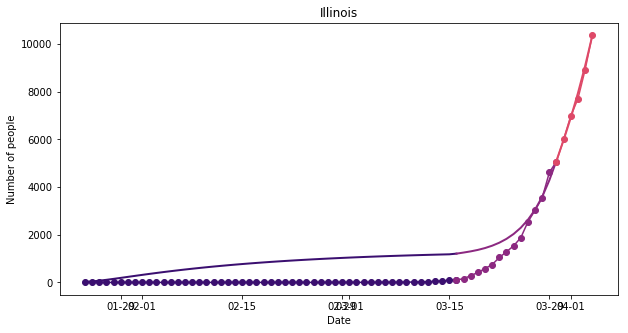

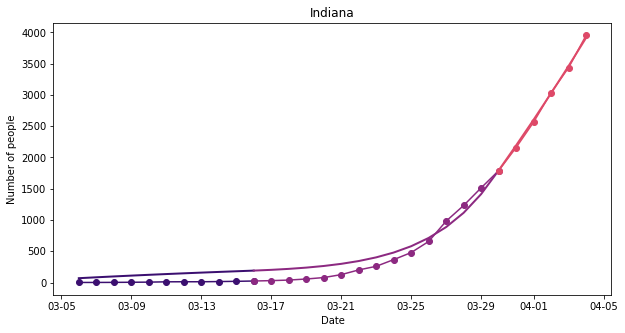

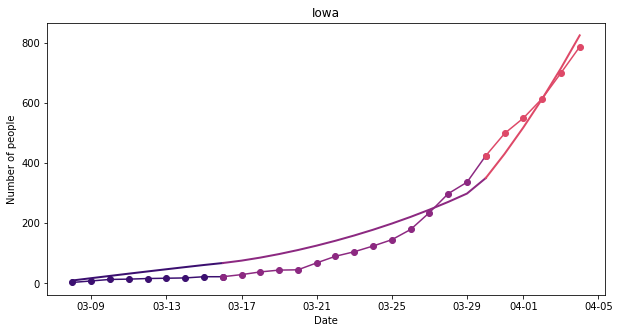

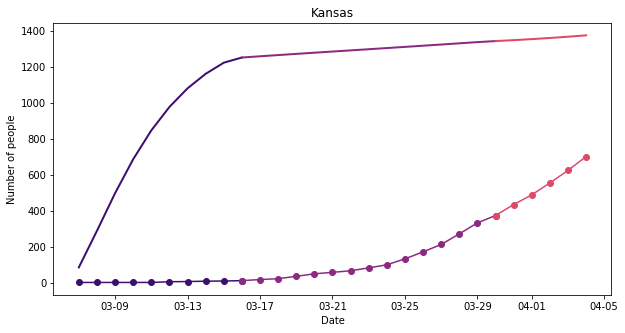

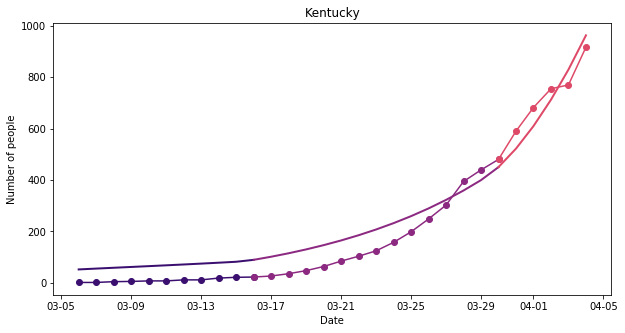

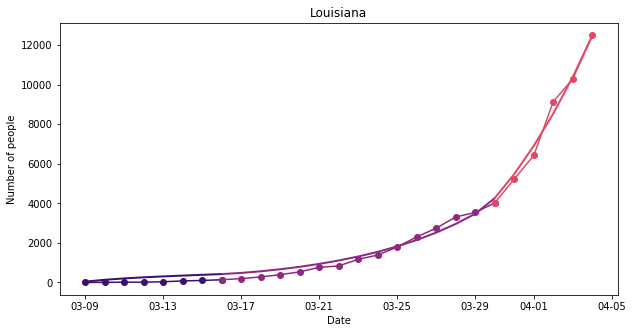

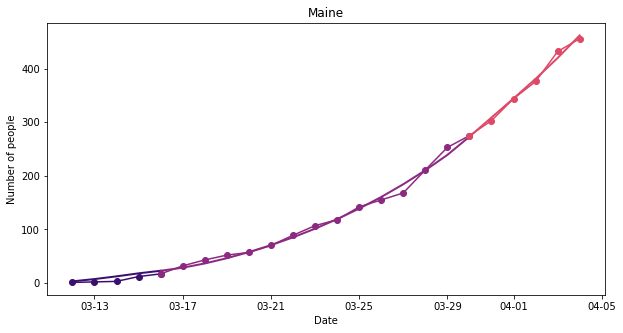

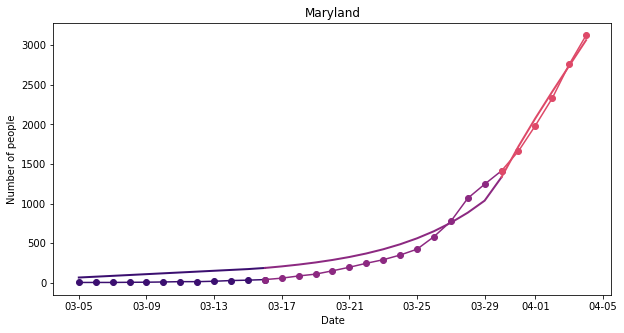

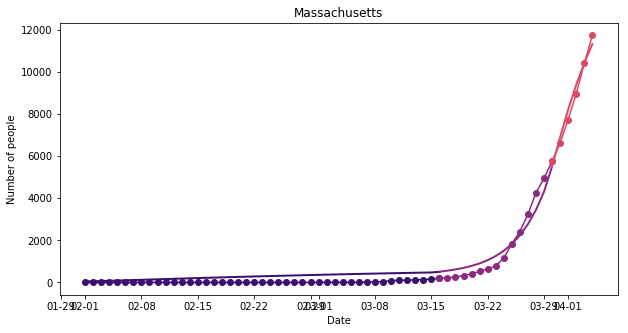

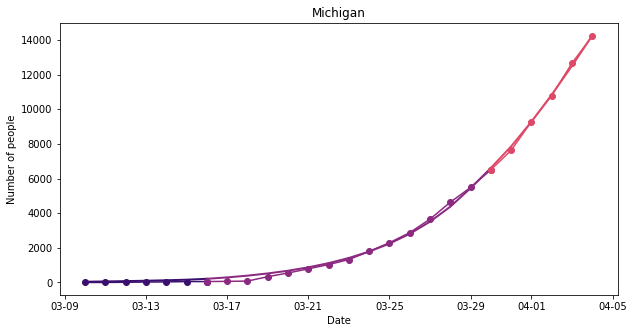

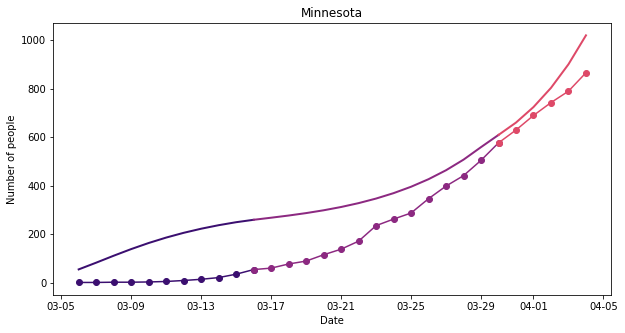

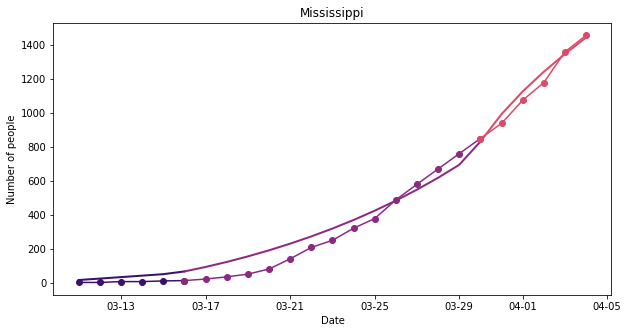

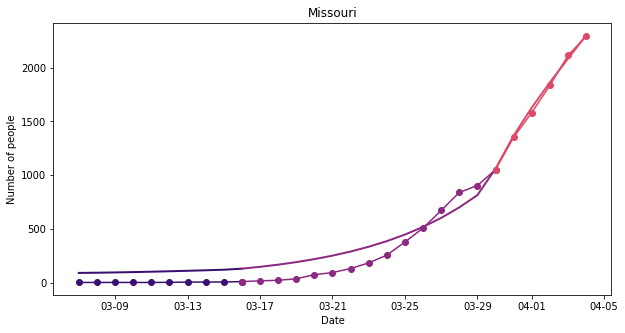

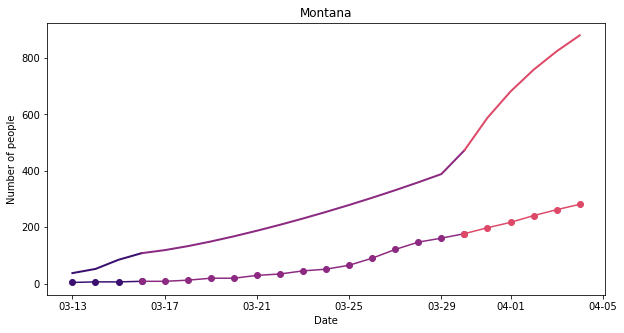

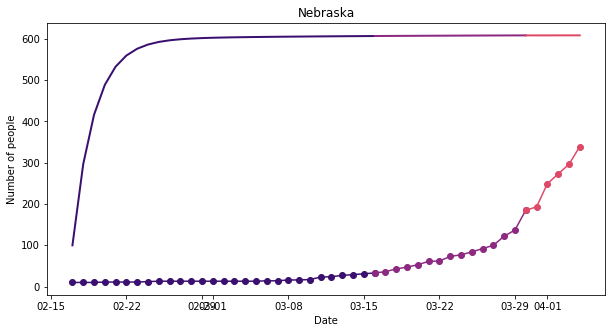

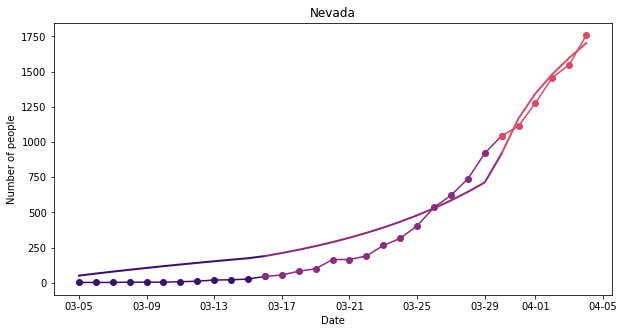

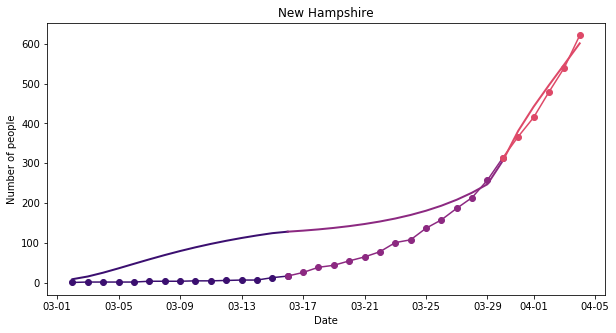

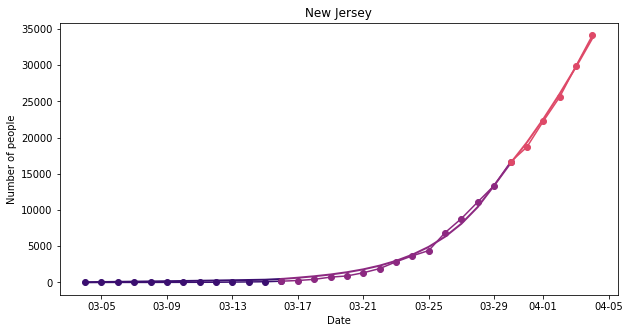

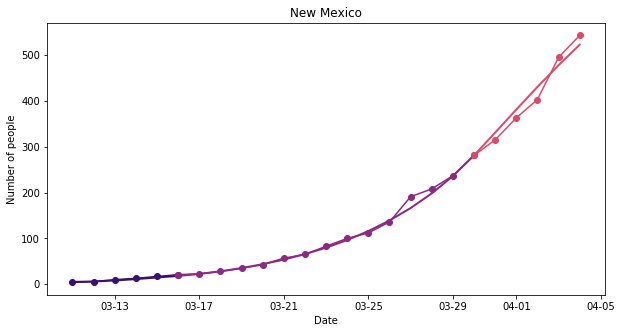

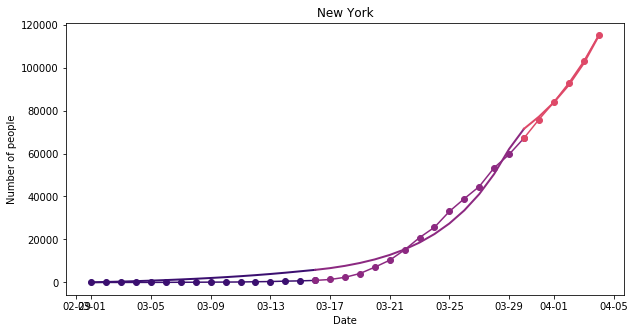

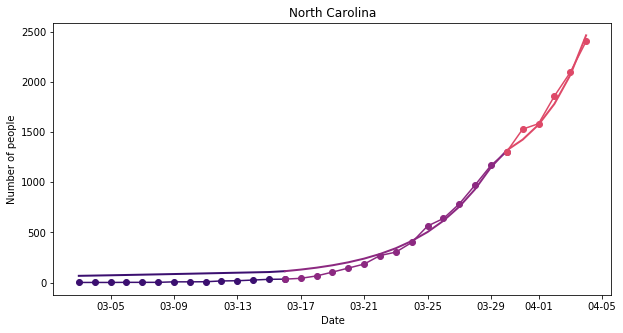

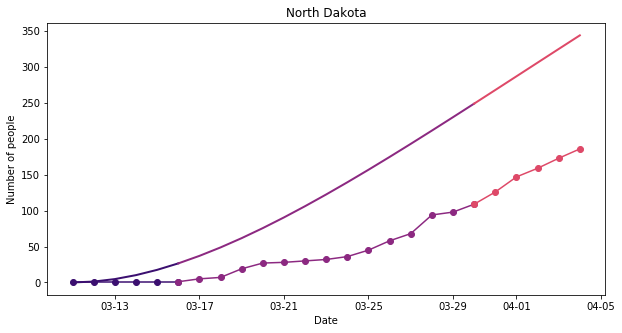

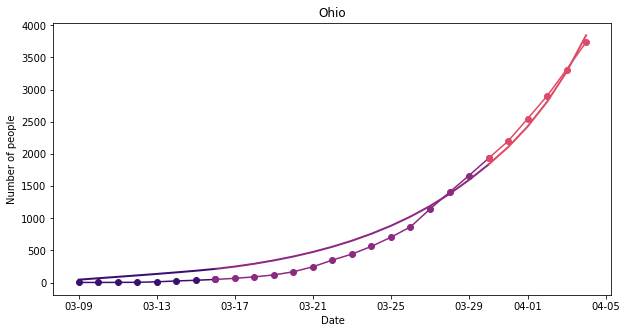

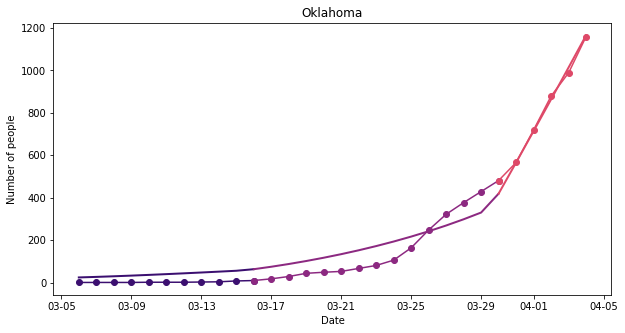

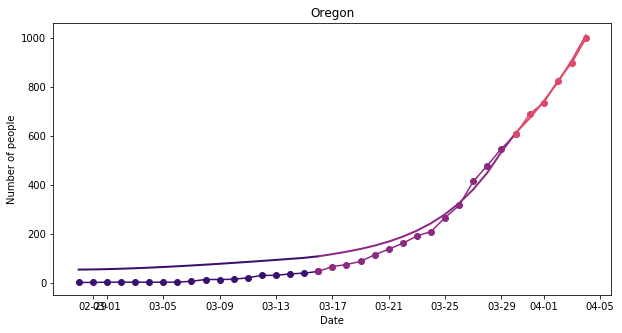

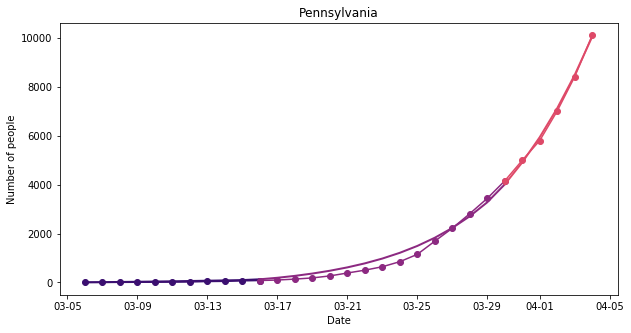

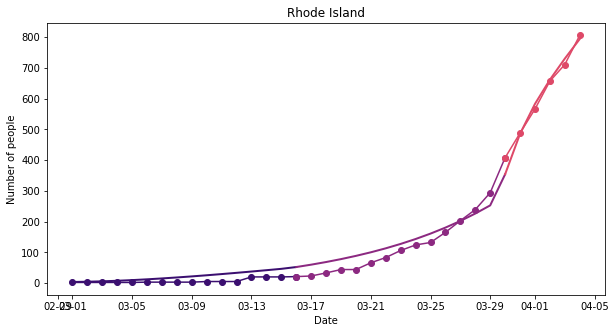

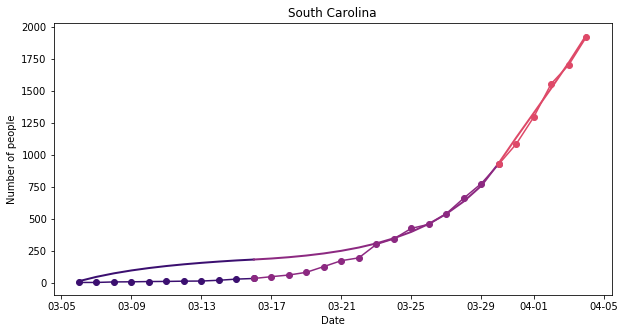

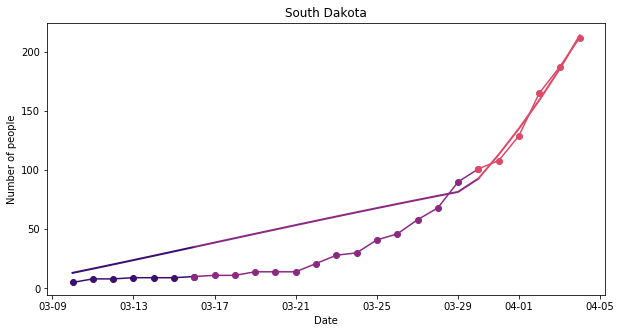

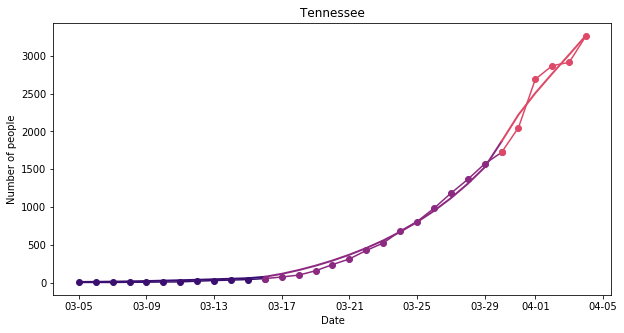

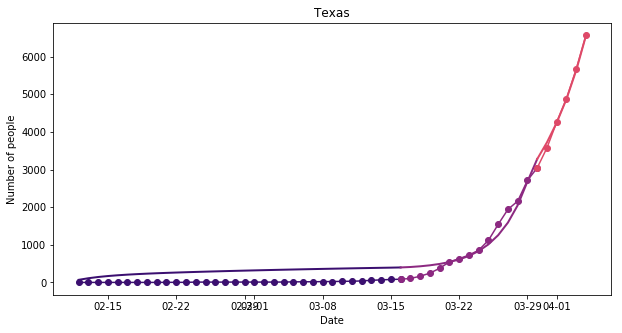

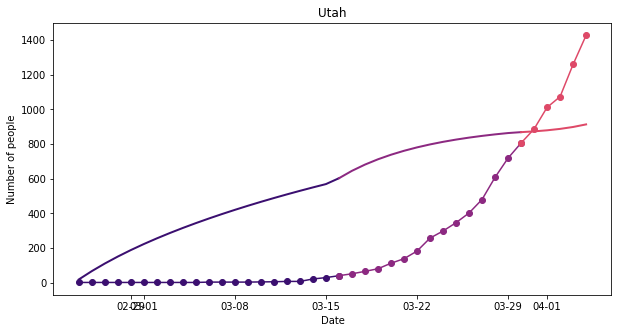

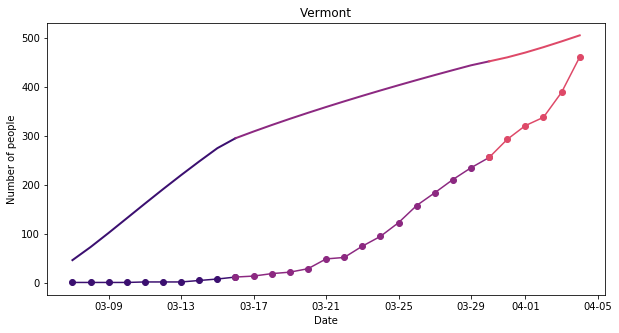

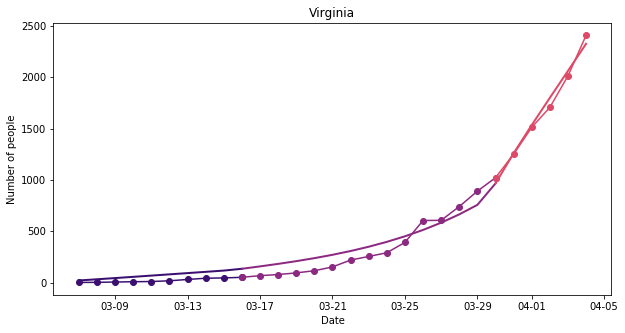

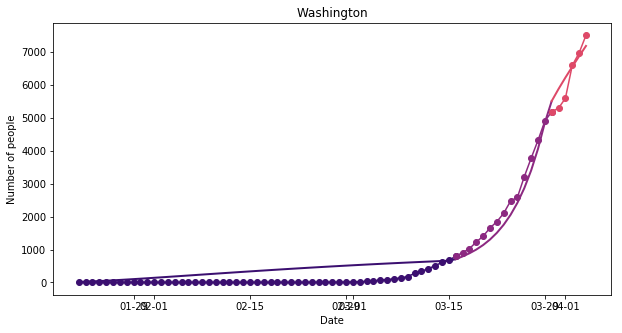

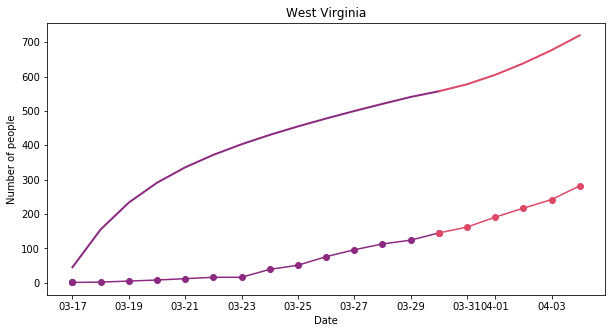

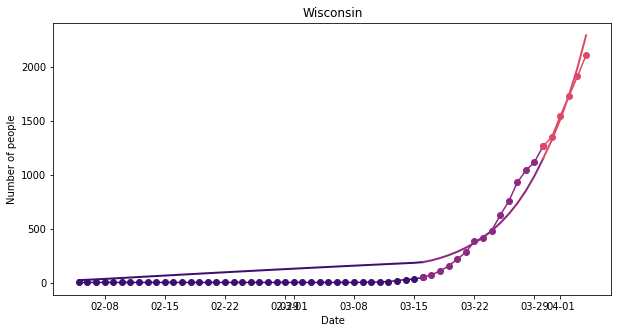

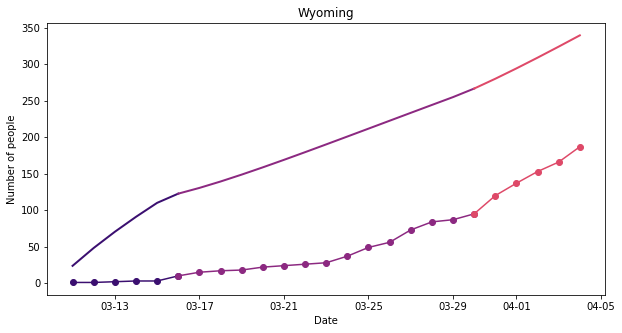

In [30]:
for rank in range(0, len(names_state)):
    simulation_state(df = data_state, update_date_tr = date_tr, update_date_sd = date_sd, 
                     rank = rank, mmethod = 'dual_annealing', kws = annealing_kws)

In [ ]:
# Parellel computing
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
if size != len(names_state):
    print("Error!")
    sys.exit()

In [ ]:
start = time.time()
result, df_parameters, df_final = simulation_state(df = data_state, update_date_tr = date_tr, update_date_sd = date_sd, 
                 rank = rank, mmethod = 'dual_annealing', kws = annealing_kws)